In [2]:
!pip install feedparser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=d865aad95ebfa44b0f53d14496f35e9d2e0612865d84e683cae536060205e73e
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [8]:
import os
import urllib.parse
import requests
import feedparser
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from datetime import datetime
import warnings

# 경고 메시지 숨김
warnings.filterwarnings("ignore")

In [13]:
# ==========================================
# 0. 설정 및 모델 로딩
# ==========================================
MODEL_DIR = "./saved_models"
MODEL_PATH = os.path.join(MODEL_DIR, "my_svm_model.pkl")
VEC_PATH = os.path.join(MODEL_DIR, "my_tfidf_vectorizer.pkl")

print("📥 모델 로딩 중...")
if not os.path.exists(MODEL_PATH) or not os.path.exists(VEC_PATH):
    raise FileNotFoundError(f"모델 파일이 {MODEL_DIR}에 없습니다. 먼저 main.py를 실행해 모델을 생성하세요.")

# 전역 변수로 모델 로드
loaded_model = joblib.load(MODEL_PATH)
loaded_vectorizer = joblib.load(VEC_PATH)
print("✅ 모델 및 벡터라이저 로드 완료!")

# 시각화 한글 폰트 설정
import platform
if platform.system() == 'Darwin':  # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # Windows
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)


📥 모델 로딩 중...
✅ 모델 및 벡터라이저 로드 완료!


In [14]:
# ==========================================
# 1. 유틸리티 함수 (티커 검색, 날짜 변환)
# ==========================================
def get_ticker_from_name(company_name):
    """기업 이름으로 야후 파이낸스 티커를 검색합니다."""
    print(f"🔎 '{company_name}'의 티커를 찾는 중...", end=" ")

    url = "https://query2.finance.yahoo.com/v1/finance/search"
    headers = {'User-Agent': 'Mozilla/5.0'}
    params = {
        'q': company_name,
        'quotesCount': 1,
        'newsCount': 0,
        'enableFuzzyQuery': 'false',
        'quotesQueryId': 'tss_match_phrase_query'
    }

    try:
        response = requests.get(url, headers=headers, params=params)
        data = response.json()
        if 'quotes' in data and len(data['quotes']) > 0:
            ticker = data['quotes'][0]['symbol']
            print(f"발견! -> [{ticker}]")
            return ticker
        else:
            print("❌ 찾을 수 없음.")
            return None
    except Exception as e:
        print(f"Error: {e}")
        return None


def standardize_date(df, date_col='Date'):
    """모든 날짜를 타임존 없는(naive) datetime 객체로 통일합니다."""
    if df.empty:
        return df

    # 1. Datetime 변환
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce', utc=True)

    # 2. UTC 정보 제거
    df[date_col] = df[date_col].dt.tz_convert(None)

    # 3. 날짜 없는 행 제거 및 정렬
    df = df.dropna(subset=[date_col]).sort_values(by=date_col).reset_index(drop=True)
    return df


In [16]:
# ==========================================
# 2. 데이터 수집 함수들
# ==========================================
def google_news_rss(keyword, start_date, end_date):
    print(f"   [Google News] '{keyword}' 검색 중...")
    s_str = start_date.strftime('%Y-%m-%d')
    e_str = end_date.strftime('%Y-%m-%d')
    query = f"{keyword} after:{s_str} before:{e_str}"
    encoded_query = urllib.parse.quote(query)
    rss_url = f"https://news.google.com/rss/search?q={encoded_query}&hl=en-US&gl=US&ceid=US:en"

    feed = feedparser.parse(rss_url)
    news_list = []
    for entry in feed.entries:
        news_list.append({
            'Date': entry.published if hasattr(entry, 'published') else None,
            'Title': entry.title,
            'Source': "Google News",
            'Text': entry.title,
            'Link': entry.link
        })
    return standardize_date(pd.DataFrame(news_list))


def yahoo_finance_news(keyword, start_date, end_date, limit=100):
    print(f"   [Yahoo Finance] '{keyword}' 관련 뉴스 수집 중...")
    s_str = start_date.strftime('%Y-%m-%d')
    e_str = end_date.strftime('%Y-%m-%d')
    search_query = f"{keyword} site:finance.yahoo.com after:{s_str} before:{e_str}"
    encoded_query = urllib.parse.quote(search_query)
    rss_url = f"https://news.google.com/rss/search?q={encoded_query}&hl=en-US&gl=US&ceid=US:en"

    feed = feedparser.parse(rss_url)
    news_list = []
    for entry in feed.entries[:limit]:
        news_list.append({
            'Date': entry.published if hasattr(entry, 'published') else None,
            'Title': entry.title,
            'Source': 'Yahoo Finance',
            'Text': entry.title,
            'Link': entry.link
        })
    return standardize_date(pd.DataFrame(news_list))


def finviz_news(ticker):
    print(f"   [Finviz] ${ticker} 뉴스 테이블 파싱 중...")
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}

    try:
        req = requests.get(url, headers=headers)
        soup = BeautifulSoup(req.content, 'html.parser')
        news_table = soup.find(id='news-table')

        if not news_table:
            return pd.DataFrame()

        parsed_data = []
        current_date = None

        for row in news_table.find_all('tr'):
            td_text = row.td.text.strip() if row.td else ""
            a_tag = row.find('a')
            if a_tag:
                link = a_tag['href']
                title = a_tag.get_text()

                if ' ' in td_text and len(td_text) > 8:
                    current_date = td_text.split(' ')[0]
                    time_str = td_text.split(' ')[1]
                else:
                    time_str = td_text

                if current_date == 'Today':
                    current_date = datetime.now().strftime("%b-%d-%y")

                if current_date:
                    full_date_str = f"{current_date} {time_str}"
                    parsed_data.append({
                        'Date': full_date_str,
                        'Title': title,
                        'Source': 'Finviz',
                        'Text': title,
                        'Link': link
                    })
        return standardize_date(pd.DataFrame(parsed_data))
    except Exception as e:
        print(f"Error reading Finviz: {e}")
        return pd.DataFrame()


In [15]:
# ==========================================
# 3. 메인 분석 및 시각화 로직 (원상복구)
# ==========================================
def run_full_analysis(keyword):
    # 1. 입력 받기
    start_str = input("분석 시작일 (YYYY-MM-DD): ")
    end_str = input("분석 종료일 (YYYY-MM-DD): ")

    ticker = get_ticker_from_name(keyword)
    if not ticker:
        print("티커를 찾지 못해 분석을 종료합니다.")
        return

    # [수정 포인트 1] 날짜 변환 시 종료일은 '해당 날짜의 끝'까지 포함하도록 설정
    start_date = pd.to_datetime(start_str)

    # end_str이 '2025-12-09'라면, 1을 더해 '2025-12-10 00:00:00' 미만으로 잡거나
    # 시간을 23:59:59로 설정해야 함. 여기서는 1일 더하는 방식 사용 (깔끔함)
    end_date_limit = pd.to_datetime(end_str) + pd.Timedelta(days=1)

    print(f"\n🚀 [{keyword} (${ticker})] 통합 여론 분석 시작 ({start_str} ~ {end_str})")

    # 2. 데이터 수집 (수집 함수에는 원래 날짜 그대로 전달)
    # 구글 뉴스와 야후는 자체 파라미터로 날짜를 거르므로 end_date를 그대로 씁니다.
    df1 = google_news_rss(keyword, start_date, pd.to_datetime(end_str))
    df2 = yahoo_finance_news(keyword, start_date, pd.to_datetime(end_str))
    df3 = finviz_news(ticker)

    # 3. 병합 및 필터링
    all_dfs = [d for d in [df1, df2, df3] if not d.empty]
    if not all_dfs:
        print("❌ 수집된 데이터가 없습니다.")
        return

    df_total = pd.concat(all_dfs, ignore_index=True)
    df_total = standardize_date(df_total)

    # [수정 포인트 2] 필터링 로직 변경 (<= end_date 대신 < end_date_limit 사용)
    # 예: 12월 9일 15시 기사 < 12월 10일 00시 (True가 됨)
    mask = (df_total['Date'] >= start_date) & (df_total['Date'] < end_date_limit)
    df_final = df_total.loc[mask].reset_index(drop=True)

    print(f"\n📊 총 {len(df_final)}개의 관련 기사 필터링 완료.")

    # 소스별 수집 개수 확인용 출력 (디버깅용)
    print(f"   ㄴ 출처별 개수: {df_final['Source'].value_counts().to_dict()}")

    if df_final.empty:
        print("해당 기간에 맞는 기사가 없습니다.")
        return

    # 4. AI 감성 분석
    print("🧠 AI 모델로 감성 분석 수행 중...")
    input_vectors = loaded_vectorizer.transform(df_final['Text'])

    if hasattr(loaded_model, 'predict'):
        predictions = loaded_model.predict(input_vectors)
    else:
        predictions = loaded_model.best_estimator_.predict(input_vectors)

    label_map = {0: 'Negative 🔴', 1: 'Neutral ⚪', 2: 'Positive 🟢'}
    df_final['Sentiment'] = [label_map[p] for p in predictions]

    # 5. 결과 시각화
    visualize_results(df_final, keyword, ticker)

    # 결과 출력
    print("\n[최신 기사 분석 샘플]")
    print(df_final[['Date', 'Source', 'Sentiment', 'Title']].tail(5))

def visualize_results(df, keyword, ticker):
    plt.figure(figsize=(14, 6))
    colors = {'Negative 🔴': '#FF4B4B', 'Neutral ⚪': '#E0E0E0', 'Positive 🟢': '#00CC66'}
    order = ['Positive 🟢', 'Neutral ⚪', 'Negative 🔴']

    # 1. 종합 비율 (Horizontal Bar)
    plt.subplot(1, 2, 1)
    counts = df['Sentiment'].value_counts()
    total = len(df)

    ratios = {k: counts.get(k, 0) / total for k in order}

    left_pos = 0
    for label in order:
        if ratios[label] > 0:
            plt.barh(0, ratios[label], left=left_pos, color=colors[label], height=0.6, edgecolor='white')
            if ratios[label] > 0.05:
                plt.text(left_pos + ratios[label] / 2, 0, f"{label}\n{ratios[label] * 100:.1f}%",
                         ha='center', va='center', color='black' if label == 'Neutral ⚪' else 'white',
                         fontweight='bold', fontsize=11)
            left_pos += ratios[label]

    plt.title(f"종합 여론 (Sentiment Balance): {keyword} (${ticker})", fontsize=15, fontweight='bold')
    plt.xlim(0, 1)
    plt.axis('off')

    # 2. 소스별 분포 (Countplot)
    plt.subplot(1, 2, 2)
    sns.countplot(data=df, x='Source', hue='Sentiment', palette=colors, hue_order=order)
    plt.title("출처별 감성 분포", fontsize=15, fontweight='bold')
    plt.xlabel("뉴스 출처")
    plt.ylabel("기사 개수")
    plt.legend(title='감성', loc='upper right')

    plt.tight_layout()
    plt.show()


분석할 기업 이름을 입력하세요 (예: Nvidia, Tesla): Tesla
분석 시작일 (YYYY-MM-DD): 2025-12-12
분석 종료일 (YYYY-MM-DD): 2025-12-19
🔎 'Tesla'의 티커를 찾는 중... 발견! -> [TSLA]

🚀 [Tesla ($TSLA)] 통합 여론 분석 시작 (2025-12-12 ~ 2025-12-19)
   [Google News] 'Tesla' 검색 중...
   [Yahoo Finance] 'Tesla' 관련 뉴스 수집 중...
   [Finviz] $TSLA 뉴스 테이블 파싱 중...

📊 총 285개의 관련 기사 필터링 완료.
   ㄴ 출처별 개수: {'Google News': 100, 'Finviz': 100, 'Yahoo Finance': 85}
🧠 AI 모델로 감성 분석 수행 중...


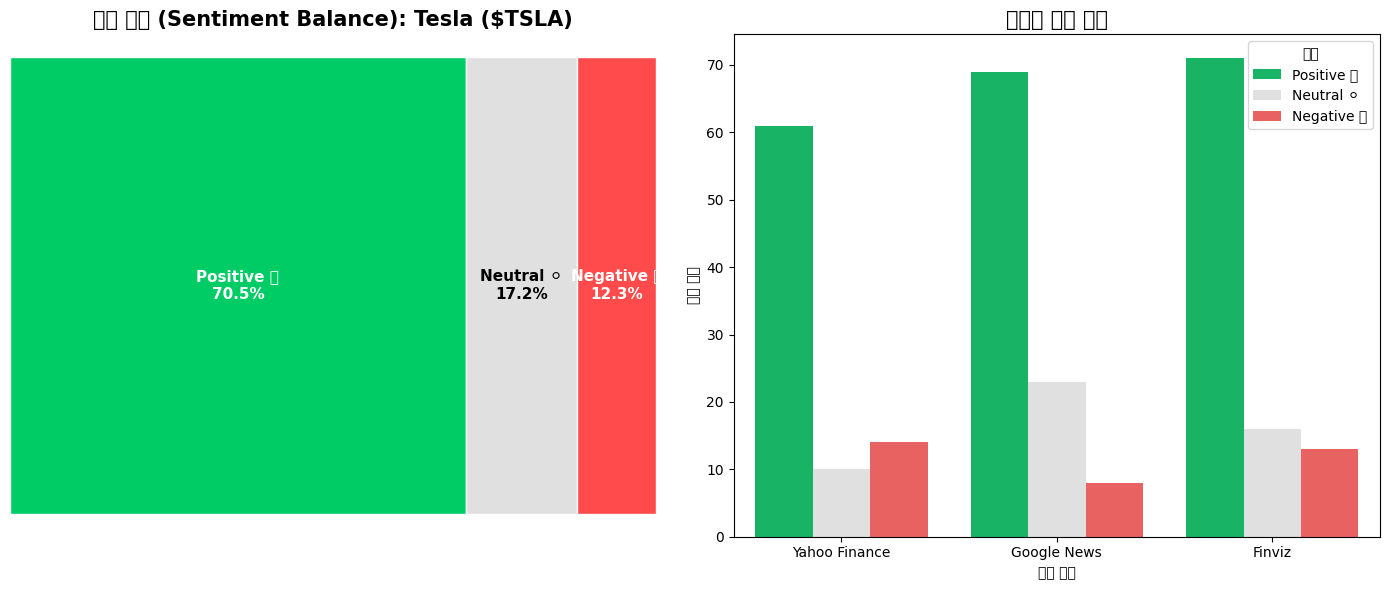


[최신 기사 분석 샘플]
                   Date         Source   Sentiment  \
280 2025-12-18 22:32:00         Finviz  Positive 🟢   
281 2025-12-18 23:08:00  Yahoo Finance  Negative 🔴   
282 2025-12-19 01:20:00         Finviz  Positive 🟢   
283 2025-12-19 03:44:20    Google News  Negative 🔴   
284 2025-12-19 03:50:00         Finviz  Positive 🟢   

                                                 Title  
280  Uber's stock is almost historically cheap. Are...  
281  Top-rated analyst drops curt 8-word take on Te...  
282  Are Democrats Still Buying Teslas? Are Republi...  
283  Tesla's 2025 holiday update brings Grok naviga...  
284  Mizuho Raises Tesla Price Target to $530, Back...  


In [17]:
if __name__ == "__main__":
    target_company = input("분석할 기업 이름을 입력하세요 (예: Nvidia, Tesla): ")
    # 최근 트렌드를 보기 위해 날짜 설정 (최근 2달 권장)
    run_full_analysis(target_company)